## Computer Vision - Assignment 2
_Abel de Wit & Martijn Hilders_

In [1]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torchvision

In [78]:
emotion_data = pd.read_csv('fer2013/fer2013.csv')

In [3]:
len(emotion_data)

35887

In [4]:
emotion_data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
emotion_data['emotion'].unique()

array([0, 2, 4, 6, 3, 5, 1])

In [6]:
emotion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


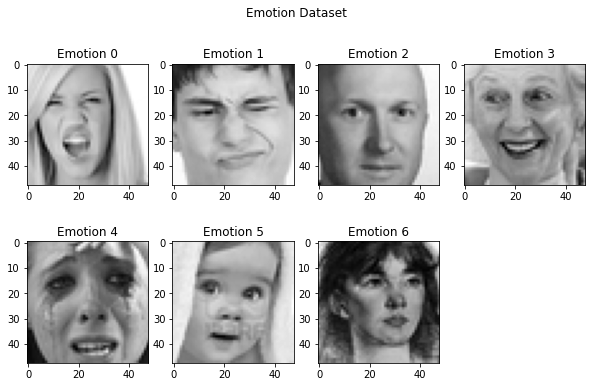

In [8]:
fig, axes = plt.subplots(figsize=(10, 6), nrows=2, ncols=4)

for c, em in enumerate(sorted(emotion_data['emotion'].unique())):
    emotion = emotion_data[emotion_data['emotion'] == em]
    emotion = emotion.reset_index()
    img_tmp = emotion['pixels'].iloc[5]
    img_0 = np.array([int(i) for i in img_tmp.split()])
    img = img_0.reshape((48, 48))
    col = c % 4
    row = c // 4
    axes[row, col].title.set_text(f'Emotion {em}')
    axes[row, col].imshow(img, cmap='gray')

axes[1, 3].set_visible(False)
plt.suptitle("Emotion Dataset")
plt.show()

In [9]:
# Checking data distribution
for em in sorted(emotion_data['emotion'].unique()):
    emotion = emotion_data[emotion_data['emotion'] == em]
    print(f'Emotion {em} has length {len(emotion)}')

Emotion 0 has length 4953
Emotion 1 has length 547
Emotion 2 has length 5121
Emotion 3 has length 8989
Emotion 4 has length 6077
Emotion 5 has length 4002
Emotion 6 has length 6198


As we can see, most emotions are around 5000 examples except for emotion 1. Here we only have 547 images to train on. 


**TODO**

* SMOTE (Augmentation)
* Image preprocessing (Contrast, Blurring, etc.)

## Time for the CNN!

In [10]:
import torch.nn as nn
from tqdm import tqdm
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential
from torch.nn import Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, random_split

In [11]:
def convert_to_img(pixel_string):
    im = np.array([int(x) for x in pixel_string.split()])
    img = im.reshape((48, 48))
    return img

emotion_data['images'] = emotion_data['pixels'].apply(convert_to_img)

In [12]:
# Splitting the data
train_emotion = emotion_data[emotion_data['Usage'] == "Training"]
pubtest_emotion = emotion_data[emotion_data['Usage'] == "PublicTest"]
pritest_emotion = emotion_data[emotion_data['Usage'] == "PrivateTest"]

len(train_emotion), len(pubtest_emotion), len(pritest_emotion)

(28709, 3589, 3589)

In [32]:
def create_tensor_data(dataframe):
    x = np.array(list(dataframe['images'])).astype('float32')
    x = x.reshape(-1, 1, 48, 48)
    
    y = dataframe['emotion'].values
    dataset = TensorDataset(torch.from_numpy(x),
                             torch.tensor(y))
    return dataset

In [33]:
train_dataset = create_tensor_data(train_emotion)
val_dataset = create_tensor_data(pubtest_emotion)
test_dataset = create_tensor_data(pritest_emotion)

(28709, 1, 48, 48) (28709,)
(3589, 1, 48, 48) (3589,)
(3589, 1, 48, 48) (3589,)


In [34]:
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

In [37]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()
device

device(type='cpu')

In [66]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels=1,
                                     out_channels=18,
                                     kernel_size=3,
                                     padding=1,
                                     stride=1
                                    )
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        self.fc1 = torch.nn.Linear(18 * 24 * 24, 1296)
        self.fc2 = torch.nn.Linear(1296, 7)
    
    def forward(self, x):
        # Layer 1 (CNN)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # Layer 2 (Feed Forward)
        x = x.view(-1, 18*24*24)
        x = self.fc1(x)
        x = F.relu(x)
        
        # Layer 3 (Feed Forward)
        x = self.fc2(x)
        x = F.relu(x)
        
        return x
    

In [77]:
from tqdm import tqdm

model = CNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

epochs = 3

for epoch in range(epochs):
    # Go over the training examples
    for batch in tqdm(train_loader):
        images, labels = batch               # Get the images and their labels

        optimizer.zero_grad()                # Reset optimizer gradients
        out = model(images)                  # Calculate models results
        loss = F.cross_entropy(out, labels)  # Calculate loss
        loss.backward()                      # Propagate back
        optimizer.step()                     # Make a step with the optimizer
    
    # Go over the validation examples
    losses = []
    for batch in tqdm(val_loader):
        images, labels = batch
        out = model(images)
        loss = F.cross_entropy(out, labels)
        losses.append(loss.detach())
        
    print(losses)
    break
    

100%|██████████| 8/8 [00:02<00:00,  3.64it/s]

[tensor(1.9459), tensor(1.9459), tensor(1.9459), tensor(1.9459), tensor(1.9459), tensor(1.9459), tensor(1.9459), tensor(1.9459)]
